In [1]:
from pathlib import Path
from shutil import copyfile
import pickle

Data manipulation

In [2]:
import numpy as np
import pandas as pd

Plotting / Visualisation

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6)

Gaussian Process Regression

In [5]:
import gpflow
import tensorflow as tf

In [6]:
from gpflow.utilities import print_summary

In [7]:
gpflow.config.set_default_summary_fmt("notebook")

MATLAB engine

In [8]:
import matlab.engine

In [9]:
eng = matlab.engine.start_matlab()

In [10]:
eng.load_system("../Simulink/polydome", background = True)

## Load weather data

Which experimental set to simulate:

In [11]:
exp_id = 'Exp7'

Copy the corresponding WDB to the model input location:

In [12]:
copyfile(f"../Data/Experimental_data_WDB/{exp_id}_WDB.mat", "../Data/input_WDB.mat")

'../Data/input_WDB.mat'

In [13]:
df_wdb = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_WDB.pkl")
df_wdb.head()

,time,timestamp,zenith,azimuth,dni,dhi,OutsideTemp,Tsky_rad,relative_humidity,precipitation,cloud_index,pressure,wind_speed,wind_direction,aoi,incidence_main,incidence_second,poa_direct,poa_diffuse
0,0,201707132000,77.726968,288.783339,32.174594,84.913015,24.0,18.0,50,-9999,0.5,96300,0,-9999,77.726968,-9999,-9999,6.839369,84.913015
1,300,201707132005,78.534908,289.630841,167.597825,88.433972,24.0,18.0,50,-9999,0.5,96300,0,-9999,78.534908,-9999,-9999,33.313565,88.433972
2,600,201707132010,79.337991,290.480180,104.009389,82.377507,24.0,18.0,50,-9999,0.5,96300,0,-9999,79.337991,-9999,-9999,19.243300,82.377507
3,900,201707132015,80.135916,291.331669,767.555215,33.326318,24.0,18.0,50,-9999,0.5,96300,0,-9999,80.135916,-9999,-9999,131.491069,33.326318
4,1200,201707132020,80.928349,292.185610,126.334677,70.317711,24.0,18.0,50,-9999,0.5,96300,0,-9999,80.928349,-9999,-9999,19.919124,70.317711


In [14]:
df = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_data.pkl")
df.head()

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,SolRad
timestamp,,,,,,
2017-07-13 20:00:00+02:00,18.827586,22.5,24.0,23.9,22.933333,91.714933
2017-07-13 20:05:00+02:00,3628.965517,22.5,24.0,15.5,23.216667,121.538700
2017-07-13 20:10:00+02:00,4391.344828,22.5,24.0,14.3,23.116667,101.481617
2017-07-13 20:15:00+02:00,4392.466667,22.5,24.0,14.0,22.800000,163.710150
2017-07-13 20:20:00+02:00,3777.482759,22.5,24.0,14.0,22.633333,90.039567


In [15]:
runtime = df_wdb['time'].iloc[-1]
print(f"Experiment runtime: {runtime}")

Experiment runtime: 554100


## Simulink

Set the CARNOT simulation initial temperature `t0`

In [16]:
eng.workspace['t0'] = float(23)

Set the CARNOT simulation air exchange rate

In [17]:
np_air = np.zeros([df_wdb.shape[0], 2])
np_air[:, 0] = df_wdb['time']
np_air[:, 1] = 2.75

In [18]:
eng.workspace['air_exchange_rate'] = matlab.double(np_air.tolist())

### Generate Heat Random Input Signal

In [19]:
Pel_max = 6300
COP_heating = 5.0
COP_cooling = 5.0

Define a function for generating random signals:

In [20]:
def get_random_signal(nstep, a_range = (-1, 1), b_range = (2, 10), signal_type = 'analog'):

    a = np.random.rand(nstep) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude
    b = np.random.rand(nstep) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
    b = np.round(b)
    b = b.astype(int)

    b[0] = 0

    for i in range(1,np.size(b)):
        b[i] = b[i-1]+b[i]
        
    if signal_type == 'analog':
        random_signal = np.zeros(nstep)
        # Random Signal
        i=0
        random_signal = np.zeros(nstep)
        while b[i]<np.size(random_signal):
            k = b[i]
            random_signal[k:] = a[i]
            i=i+1
        return random_signal
    elif signal_type == 'prbs':
        
        # PRBS
        a = np.zeros(nstep)
        j = 0
        while j < nstep:
            a[j] = a_range[1]
            a[j+1] = a_range[0]
            j = j+2

        i=0
        prbs = np.zeros(nstep)
        while b[i]<np.size(prbs):
            k = b[i]
            prbs[k:] = a[i]
            i=i+1
            
        return prbs
    else:
        raise NotImplementedError

In [21]:
len_signal = len(df_wdb)

random_signal = get_random_signal(len_signal, a_range = (- COP_cooling * Pel_max, COP_heating * Pel_max), signal_type = 'analog')
prbs = get_random_signal(len_signal, a_range = (0, 5), signal_type = 'prbs')

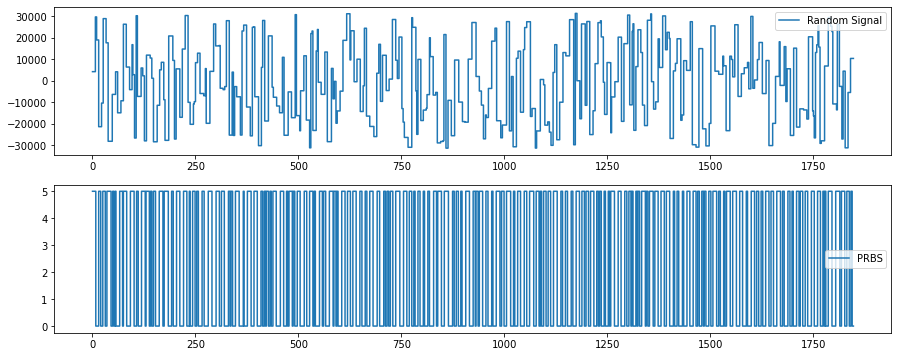

In [22]:
plt.figure() 
plt.subplot(2,1,1)
plt.plot(random_signal, drawstyle='steps',label='Random Signal')
plt.legend()
plt.subplot(2,1,2)
plt.plot(prbs, drawstyle='steps', label='PRBS')
plt.legend()
plt.show()

Get the original electric power consumption

In [23]:
power = np.array([df_wdb['time'], random_signal]).T

Get the heating power by passing through a heating/cooling COP

In [24]:
eng.workspace['power'] = matlab.double(power.tolist())

### Set the simulation parameters and run it

In [25]:
eng.set_param('polydome', 'StopTime', str(runtime), nargout = 0)

In [26]:
eng.workspace['result'] = eng.sim('polydome')

### Interpret the simulation results

In [27]:
def carnot_to_series(eng, start_timestamp):

    # Compile the simulation dict
    dict_simulation = {}
    dict_simulation['SimulatedTemp'] = np.asarray(eng.eval('result.SimulatedTemp.Data')).reshape(-1)
    dict_simulation['time'] = np.asarray(eng.eval('result.SimulatedTemp.Time')).reshape(-1)
    
    # Create the dataframe from dict
    df_simulation = pd.DataFrame(dict_simulation)
    df_simulation.set_index('time', inplace = True, drop = True)
    
    # Define the timestamps and set it as index
    df_simulation['timestamp'] = start_timestamp + df_simulation.index.map(lambda x: pd.Timedelta(seconds = x))
    df_simulation = df_simulation.reset_index().set_index('timestamp')
    
    # Resample the dataframe to 5 min intervals
    # Taking the mean when there are multiple points, padding with zero order when data is missing
    df_simulation = df_simulation['SimulatedTemp'].resample('5min').mean().pad()
    
    return df_simulation

In [28]:
df_simulation = carnot_to_series(eng, df.index[0])

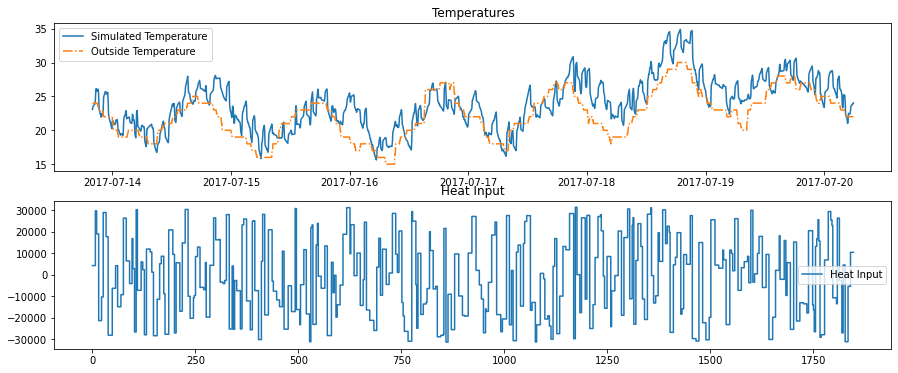

In [29]:
plt.figure() 
plt.subplot(2,1,1)
plt.plot(df_simulation.index, df_simulation, label = 'Simulated Temperature')
plt.plot(df.index, df['OutsideTemp'], '-.', label = 'Outside Temperature')
plt.title('Temperatures')
plt.legend()
plt.subplot(2,1,2)
plt.plot(power[:, 1], drawstyle = 'steps', label = 'Heat Input')
plt.title('Heat Input')
plt.legend()
plt.show()

Add the outputs to the experimental df: 

In [30]:
df.loc[:,'SimulatedTemp'] = df_simulation
df.loc[:,'SimulatedHeat'] = power[:, 1]

In [31]:
df

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,SolRad,SimulatedTemp,SimulatedHeat
timestamp,,,,,,,,
2017-07-13 20:00:00+02:00,18.827586,22.5,24.0,23.9,22.933333,91.714933,23.084581,4239.488599
2017-07-13 20:05:00+02:00,3628.965517,22.5,24.0,15.5,23.216667,121.538700,23.461498,4239.488599
2017-07-13 20:10:00+02:00,4391.344828,22.5,24.0,14.3,23.116667,101.481617,23.586236,4239.488599
2017-07-13 20:15:00+02:00,4392.466667,22.5,24.0,14.0,22.800000,163.710150,23.675021,4239.488599
2017-07-13 20:20:00+02:00,3777.482759,22.5,24.0,14.0,22.633333,90.039567,23.764361,4239.488599
...,...,...,...,...,...,...,...,...
2017-07-20 05:35:00+02:00,9.517241,22.5,22.0,23.6,22.766667,3.260000,23.734483,10384.873952
2017-07-20 05:40:00+02:00,5.666667,22.5,22.0,23.6,22.733333,3.250000,23.806762,10384.873952
2017-07-20 05:45:00+02:00,9.137931,22.5,22.0,23.6,22.750000,3.240000,23.806762,10384.873952


## Gaussian Process Regression

### Load Gaussian Process Regression Model

In [32]:
model_path = Path(Path.cwd(), 'model')

In [33]:
def load_gpr(model_path):
    x_scaler = pickle.load(open(Path(model_path, 'x_scaler.pkl'), 'rb'))
    m_params = pickle.load(open(Path(model_path, 'gp_params.gpf'), 'rb'))
    m_data = pickle.load(open(Path(model_path, 'gp_data.gpf'), 'rb'))

    k = gpflow.kernels.SquaredExponential(lengthscales=([1] * m_data[0].shape[1])) + gpflow.kernels.Constant()

    m = gpflow.models.GPR(
        data = m_data, 
        kernel = k, 
        mean_function = None
        )
    
    gpflow.utilities.multiple_assign(m, m_params)
    
    return x_scaler, m

In [34]:
x_scaler, m = load_gpr(model_path)

In [35]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,672551.1934857197
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(7,)",float64,"[2.96352201e+05, 4.54452962e+05, 4.06450919e+02..."
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,676495.6894024109
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.10898288218871159


In [36]:
def data_to_gpr(df, lu = 2, ly = 3, dyn_in = 'SimulatedHeat', dyn_out = 'SimulatedTemp'):
    
    df_gpr = df[['OutsideTemp', 'SolRad', 'SimulatedTemp', 'SimulatedHeat']].copy()
    df_gpr.rename(columns = {dyn_in: 'u', dyn_out: 'y'}, inplace = True)
    
    # Add the regressive inputs/outputs
    for idx in range(1, lu + 1):
        df_gpr.loc[:, f"u_{idx}"] = df_gpr['u'].shift(idx)

    for idx in range(1, ly + 1):
        df_gpr.loc[:, f"y_{idx}"] = df_gpr['y'].shift(idx)

    df_gpr.dropna(inplace = True)
    
    return df_gpr

In [37]:
df_gpr = data_to_gpr(df)
df_gpr.head()

,OutsideTemp,SolRad,y,u,u_1,u_2,y_1,y_2,y_3
timestamp,,,,,,,,,
2017-07-13 20:15:00+02:00,24.0,163.710150,23.675021,4239.488599,4239.488599,4239.488599,23.586236,23.461498,23.084581
2017-07-13 20:20:00+02:00,24.0,90.039567,23.764361,4239.488599,4239.488599,4239.488599,23.675021,23.586236,23.461498
2017-07-13 20:25:00+02:00,24.0,74.428250,23.810838,4239.488599,4239.488599,4239.488599,23.764361,23.675021,23.586236
2017-07-13 20:30:00+02:00,24.0,70.027167,23.881527,4239.488599,4239.488599,4239.488599,23.810838,23.764361,23.675021
2017-07-13 20:35:00+02:00,24.0,70.906667,24.481502,4239.488599,4239.488599,4239.488599,23.881527,23.810838,23.764361


In [38]:
df_input = df_gpr.drop(columns = ['u', 'y'])
df_output = df_gpr['y']

In [39]:
np_input = df_input.to_numpy()
np_output = df_output.to_numpy().reshape(-1, 1)

In [40]:
np_input_sc = x_scaler.transform(np_input)

In [41]:
mean, var = m.predict_y(np_input_sc)

### Evaluate performance of loaded model

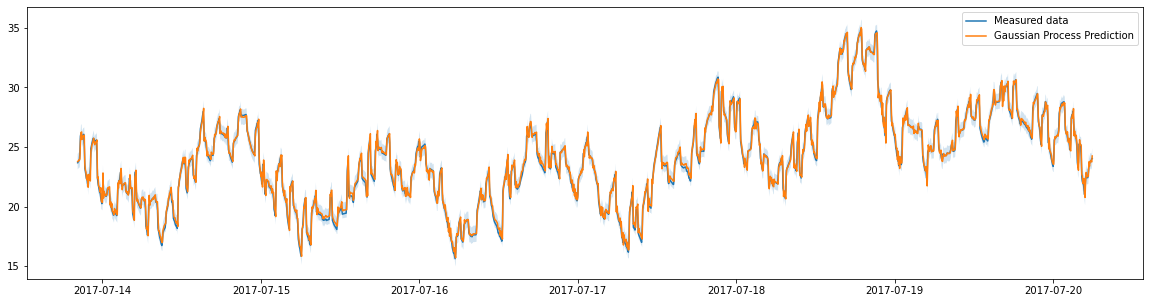

In [42]:
plt.figure(figsize = (20, 5))
plt.plot(df_gpr.index, np_output[:, :], label = 'Measured data')
plt.plot(df_gpr.index, mean[:, :], label = 'Gaussian Process Prediction')
plt.fill_between(
    df_gpr.index, 
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),from pathlib import Path

from shutil import copyfile

import pickle

Load the general math/data manipulation packages

import numpy as np

import pandas as pd

Load the packages related to the Gaussian Process Regressor:

import gpflow

import tensorflow as tf

from gpflow.utilities import print_summary

gpflow.config.set_default_summary_fmt("notebook")

tf.config.set_visible_devices([], 'GPU')

import matplotlib.pyplot as plt

Load the CasADi package used for optimization:

import casadi

Import MATLAB engine and start it in the background since this takes a while:

import matlab.engine

eng = matlab.engine.start_matlab()

eng.load_system("../Simulink/polydome", background = True)

<matlab.engine.futureresult.FutureResult at 0x7f211ba8ec40>

Copy the experimental data set to the CARNOT input location:

    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    alpha = 0.2
)
plt.legend()
plt.show()